In [1]:
# import packages
from caveclient import CAVEclient
import pandas as pd
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cmocean

In [2]:
# need a caveclient token to access the data. see https://caveclient.readthedocs.io/en/latest/guide/authentication.html for information on getting a token

client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [3]:
# time of materialization for data used in the paper
import datetime
timestamp_then = datetime.datetime(2023, 5, 15, 20, 35, 47, 161789)

In [4]:
# get left wing MNs from cave annotation table
wing_table = client.materialize.query_table('wing_motor_neuron_table_v0')

wing_table['side'] = [x.strip()[-1] for x in wing_table.classification_system]
wingL_table = wing_table[wing_table.side.isin(['L'])]

wing_MN_table = wingL_table[~wingL_table.cell_type.isin(['nonMN_unk3','nonMN_unk2','nonMN_unk1','nonMN_PSI','tt','ttb_u','ttc_u'])] # other efferent neurons
wing_MN_table.shape # should be 30

(30, 10)

In [5]:
# query for the full connectivity matrix
full_df = client.materialize.synapse_query(post_ids = wing_MN_table.pt_root_id.to_list())

In [6]:
# threshold for how many synapses to count as an upstream partners

def group_and_count_inputs(df, thresh):

    # count the number of synapses between pairs of pre and post synaptic inputs
    syn_in_conn=df.groupby(['pre_pt_root_id','post_pt_root_id']).transform(len)['id']
    # save this result in a new column and reorder the index
    df['syn_in_conn']=syn_in_conn
    df = df[['id', 'pre_pt_root_id','post_pt_root_id','score','syn_in_conn']].sort_values('syn_in_conn', ascending=False).reset_index()

    # Filter out small synapses between pairs of neurons and now print the shape
    df = df[df['syn_in_conn']>=thresh]
    # print(df.shape)
    return df

In [7]:
thresh = 3 # minimum number of synapses to count as a connection
syn_df = group_and_count_inputs(full_df, thresh = 3)
print("{} synapses before thresholding".format(len(full_df)))
print("{} synapses with a {} synapse threshold".format(len(syn_df), thresh))

183663 synapses before thresholding
163689 synapses with a 3 synapse threshold


In [8]:
# use the premotor annotation table to filter out fragments
premotor_df = client.materialize.query_table('wing_premotor_v4')
premotor_df = premotor_df[premotor_df.classification_system.isin(['local','local_intersegmental','descending','ascending','sensory'])]

syn_df_premotor = syn_df[syn_df.pre_pt_root_id.isin(premotor_df.pt_root_id.to_list())]
print("{} synapses with a {} synapse threshold and proofread preMNs".format(len(syn_df_premotor), thresh))

151030 synapses with a 3 synapse threshold and proofread preMNs


In [9]:
# adjaceny matrix
adj = pd.crosstab(syn_df_premotor.pre_pt_root_id, syn_df_premotor.post_pt_root_id)

In [10]:
# order the columns by motor module
MN_order = ['DLM_1', 'DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 'DVM_1a', 'DVM_1b', 'DVM_1c', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'PS1', 'PSn_u', 'PS2', 'dtpmn_u', 'tp2', 'tpn', 'iii1', 'iii3', 'i2_u', 'i1', 'b3_u', 'b2', 'b1', 'hg2', 'hg1_u', 'hg3', 'hg4', 'iii4a_u']
MN_dict = dict(zip(wing_MN_table.pt_root_id, wing_MN_table.cell_type))
 
#rename columns in DataFrame using dictionary
adj.rename(columns=MN_dict, inplace=True)
adj_ordered = adj[MN_order]


In [11]:
# order the preMNs
# order preMNs by cell class, preferred pool, synapse number

# First, find the module preferred by each preMN

# modules
DLM_mod = ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5']
DVM_mod = ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b']
tension_mod = ['PS1','PSn_u','PS2','dtpmn_u','tp2']
steerA_mod = ['tpn','iii1','iii3']
steerB_mod = ['i2_u','i1','b3_u']
steerC_mod = ['b2','b1']
hg2_mod = ['hg2']
steerD_mod = ['hg1_u','hg3','hg4','iii4a_u']

In [12]:
preMN_prefs = pd.DataFrame(adj_ordered.sum(axis=1).rename_axis('pt_root_id').reset_index(name='MN_syn_total'))
preMN_prefs['DLM_syn'] = adj_ordered.loc[:,DLM_mod].sum(axis=1).to_list()
preMN_prefs['DVM_syn'] = adj_ordered.loc[:,DVM_mod].sum(axis=1).to_list()
preMN_prefs['tension_syn'] = adj_ordered.loc[:,tension_mod].sum(axis=1).to_list()
preMN_prefs['steerA_syn'] = adj_ordered.loc[:,steerA_mod].sum(axis=1).to_list()
preMN_prefs['steerB_syn'] = adj_ordered.loc[:,steerB_mod].sum(axis=1).to_list()
preMN_prefs['steerC_syn'] = adj_ordered.loc[:,steerC_mod].sum(axis=1).to_list()
preMN_prefs['steerhg2_syn'] = adj_ordered.loc[:,hg2_mod].sum(axis=1).to_list()
preMN_prefs['steerD_syn'] = adj_ordered.loc[:,steerD_mod].sum(axis=1).to_list()

In [13]:
# as a check, should be 0
(preMN_prefs['MN_syn_total'].to_list() - preMN_prefs.iloc[:,2:].sum(axis=1)).sum()

0

In [14]:
# assign preferred pool
preMN_prefs['pref'] = ''
temp_df = preMN_prefs.iloc[:,2:-1].astype(float)

i = 0
while i < len(preMN_prefs):
    preMN_prefs['pref'].iloc[i] = temp_df.loc[i].idxmax()
    i = i + 1

preMN_prefs.head()

/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_61927/1911054723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preMN_prefs['pref'].iloc[i] = temp_df.loc[i].idxmax()
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_61927/1911054723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preMN_prefs['pref'].iloc[i] = temp_df.loc[i].idxmax()
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_61927/1911054723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,pt_root_id,MN_syn_total,DLM_syn,DVM_syn,tension_syn,steerA_syn,steerB_syn,steerC_syn,steerhg2_syn,steerD_syn,pref
0,648518346459413252,38,0,0,0,0,0,38,0,0,steerC_syn
1,648518346459520004,296,138,70,88,0,0,0,0,0,DLM_syn
2,648518346459550468,49,49,0,0,0,0,0,0,0,DLM_syn
3,648518346459573508,89,0,0,0,5,84,0,0,0,steerB_syn
4,648518346459589380,26,0,0,0,0,26,0,0,0,steerB_syn


In [15]:
# add cell class label to preference df for ordering
preMN_prefs = preMN_prefs.merge(premotor_df[['pt_root_id','classification_system']], how='left')
len(preMN_prefs)

1787

In [16]:
# ordering info
pref_order = ['DLM_syn','DVM_syn','tension_syn','steerA_syn','steerB_syn','steerC_syn','steerhg2_syn','steerD_syn']
class_order = ['ascending','descending','sensory','local_intersegmental','local']

from pandas.api.types import CategoricalDtype
pref_order = CategoricalDtype(
    pref_order, 
    ordered=True
)

from pandas.api.types import CategoricalDtype
class_order = CategoricalDtype(
    class_order, 
    ordered=True
)

In [17]:
# order the preMNs
# order preMNs by cell class, preferred pool, synapse number

preMN_prefs['pref'] = preMN_prefs['pref'].astype(pref_order)
preMN_prefs['classification_system'] = preMN_prefs['classification_system'].astype(class_order)

sorted_preMNs = preMN_prefs.sort_values(by = ['classification_system','pref','MN_syn_total'], ascending=[True,True,False]).pt_root_id.to_list()

In [18]:
MNpreMN_ordered_adj = adj_ordered.reindex(sorted_preMNs)
len(MNpreMN_ordered_adj)

1787

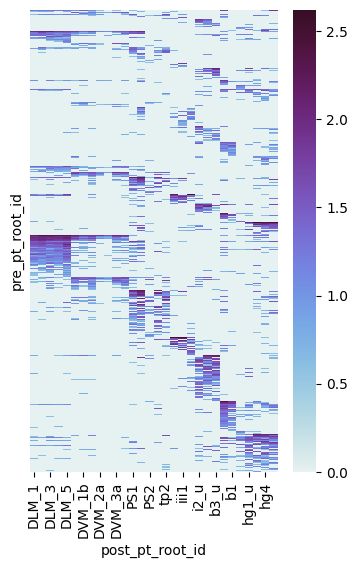

In [19]:
# check that matrix looks normal
fig = plt.figure(1, figsize = [4,6])
cmap = cmocean.cm.dense

log_df = np.log10(MNpreMN_ordered_adj +1)
ax = sns.heatmap(log_df, cmap = cmap, yticklabels = '')

plt.show()

In [21]:
# make a multi index dataframe 

df = preMN_prefs
df = df.merge(premotor_df[['pt_root_id','cell_type']], how='left')
df = df.rename(columns={"pt_root_id":"pre_pt_root_id"})

labeled_adj = MNpreMN_ordered_adj.reset_index().merge(df[['pre_pt_root_id','pref','classification_system','cell_type']], how='left')
labeled_adj = labeled_adj.rename(columns={"pref": "preferred_module"})
labeled_adj = labeled_adj.rename(columns={"classification_system":"cell_class"})
len(labeled_adj)

1793

In [22]:
# add neurotransmitter info - only to local and intersegmental neurons
# NT lists - according to Lacin et al 2019
GABA_list = ['11B', '0A', '6A', '3B', '5B', '19A', '6B', '12B', '13B', '13A','9A','1B']
Glu_list = ['2A', '16B', '8A', '21A', '14A', '24B_'] #'15B', 
ACh_list = ['17A', '12A', '8B', '19B', '11A', '7B', '23B', '18B', '1A', '20A', '4B', '3A', '22A','10B','PSI']

labeled_adj['putative_NT'] = 'unk' #unknown
labeled_adj.loc[labeled_adj['cell_type'].isin(ACh_list), 'putative_NT'] = 'ACh'
labeled_adj.loc[labeled_adj['cell_type'].isin(GABA_list), 'putative_NT'] = 'GABA'
labeled_adj.loc[labeled_adj['cell_type'].isin(Glu_list), 'putative_NT'] = 'Glu'

In [23]:
multi_df = labeled_adj.set_index(['pre_pt_root_id', 'preferred_module', 'cell_type', 'cell_class','putative_NT'])

In [25]:
multi_df.to_pickle("./wingMN_adj_0524.pkl")